/home/nicholas/anaconda3/envs/ds/lib/python3.9/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


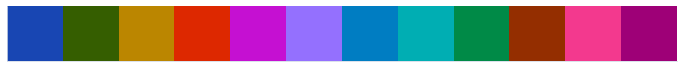

In [1]:
import numpy as np
import networkx as nx
from scipy import stats
import matplotlib.pyplot as plt
import rho_plus as rp
import seaborn as sns
import pandas as pd

IS_DARK = False
theme, cs = rp.mpl_setup(IS_DARK)

sns.palplot(cs)
from matrix_chain import *

In [2]:
def standardize(x):
    return (x - np.min(x)) / np.ptp(x)

def draw(dims, harcs=[], varcs=[], show=True):
    nodes = list(enumerate(dims))    
    labels = {(i, dim): dim for i, dim in enumerate(dims)}
    g: nx.Graph = nx.cycle_graph(nodes)    
    nodes.append(nodes[0])
    for edge in harcs:
        if (nodes[edge.v1], nodes[edge.v2]) not in g.edges and nodes[edge.v1] != nodes[edge.v2]:
            g.add_edge(nodes[edge.v1], nodes[edge.v2], color=cs[0])

    for edge in varcs:
        if (nodes[edge.v1], nodes[edge.v2]) not in g.edges:
            g.add_edge(nodes[edge.v1], nodes[edge.v2], color=cs[1])

    R = 3
    xpos = np.linspace(-1, 1, len(dims))
    ypos = standardize(dims) ** (1 / 3)
    pos = {n: (xpos, ypos) for n, xpos, ypos in zip(nodes, xpos, ypos)}    
    kwargs = dict(node_size=500, font_color=plt.rcParams['text.color'], font_size=18, width=2, node_color=plt.rcParams['axes.facecolor'],
                  font_family='monospace')
    ecs = [c for (u, v, c) in g.edges.data('color', default='#000000')]

    edge_labels = {(nodes[arc.v1], nodes[arc.v2]): f'{arc.cutoff:.1f}' for arc in harcs if arc.v2 - arc.v1 != 1}        

    if show:
        fig, ax = plt.subplots(figsize=(5, 5))
        plt.rcParams['figure.figsize'] = (5, 5)
        nx.draw_networkx(g, pos=pos, labels=labels, edge_color=ecs, **kwargs, ax=ax)
        nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=edge_labels, font_size=13, font_family='monospace')
        plt.show()
    return g

In [3]:
import heapq
def postorder_traversal(f, leaves):
    """Computes f(root), where f depends on the children.
    Uses iteration to avoid stack overflow."""
    processed = set()
    frontier = set(leaves)
    while frontier:
        node = frontier.pop()
        if set(node.children).issubset(processed):
            result = f(node)
            processed.add(node)

            if node.parent is not None:
                frontier.add(node.parent)

    return result

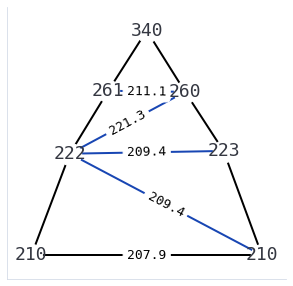

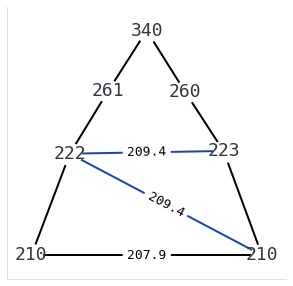

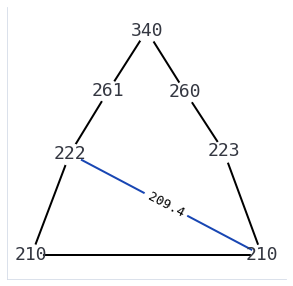

In [4]:
from networkx import is_isomorphic

done = False
dims2 = np.array([210, 222, 261, 340, 260, 223])
offset = np.argmin(dims2)
dims = np.roll(dims2, -offset, axis=0)
dims = np.hstack([dims, dims[0]])

def compute_ceiling(node, arcs, exclude=()):
    """Computes the ceiling, or covering set, of arcs above node."""
    iset = IntervalSet([(node.v1, node.v2)])
    ceiling = []
    for edge in sorted(arcs):
        if (
            not iset.contains((edge.v1, edge.v2)) 
            and edge not in ceiling
            and edge not in exclude
        ):
            iset -= (edge.v1, edge.v2)
            ceiling.append(edge)

    return ceiling

def find_ceiling(node):
    if len(node.children) == 0:
        node.ceiling = set()
        node.matrix_product = None
    else:
        vmin = node.v1 if dims[node.v1] <= dims[node.v2] else node.v2
        wmin = dims[vmin]
        frontier = set(node.children)
        node.ceiling = set()
        jumps = {}
        rjumps = {}

        while frontier:
            child = frontier.pop()
            if child.cutoff <= wmin:
                node.ceiling.add(child)
            else:
                frontier.update(child.ceiling)

    return node.ceiling

# mats = [np.random.randn(n, m) for n, m in zip(dims[:-1], dims[1:])]

node, cost, arcs, leaves = optimal_matrix_chain_cost(dims2)
leaves = [a for a in arcs if len(a.children) == 0]

draw(dims, arcs)
harcs = [a for a in arcs if a.cutoff <= dims[0] and len(a.children)]    

g1 = draw(dims, harcs)

ceiling = postorder_traversal(find_ceiling, leaves)
g2 = draw(dims, ceiling)

In [5]:
from test_correctness import dp_matrix_cost


dp_matrix_cost(dims)

71195340

In [6]:
print(222 * (223 * 260 + 260 * 340 + 340 * 261) + 210 * 222 * 223 + 210 * 222 * 210)
print(260 * 340 * 261 + 222 * 261 * 260 + 222 * 260 * 223 + 210 * 222 * 223 + 210 * 222 * 210)

72383100
71195340


In [7]:
from functools import reduce

cost = 0
def trace_dot(a, b):
    if a is None:
        return b
    if b is None:
        return a
    p, q = a.shape
    q2, r = b.shape
    print(f'({p} x {q}) @ ({q2} x {r})')
    global cost
    cost += p * q * r
    return np.dot(a, b)

In [8]:
def find_all_included_harcs(node):
    if len(node.children) == 0:
        node.included = set()        
    else:
        vmin = node.v1 if dims[node.v1] <= dims[node.v2] else node.v2
        wmin = dims[vmin]
        frontier = set(node.ceiling)
        ceiling_nodes = set()
    
        node.included = set()
        while frontier:
            child = frontier.pop()
            node.included.add(child)
            node.included.update(child.included)        

        

    return node.included

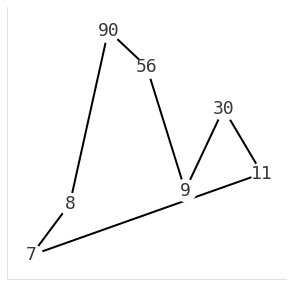

[(7, 8), (8, 90), (90, 56), (56, 9), (9, 30), (30, 11)]


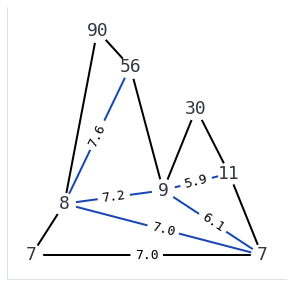

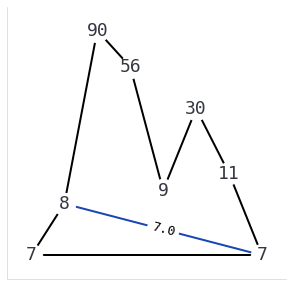

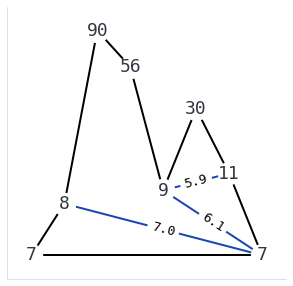

In [9]:
dims2 = np.array([7, 8, 90, 56, 9, 30, 11])
draw(dims2)
mats1 = [np.random.randn(n, m) for n, m in zip(dims2[:-1], dims2[1:])]
offset = np.argmin(dims2)
dims = np.roll(dims2, -offset, axis=0)
dims = np.hstack([dims, dims[0]])
node, cost, arcs, leaves = optimal_matrix_chain_cost(dims2)
harcs = [a for a in arcs if a.cutoff <= dims[0] and len(a.children)]
ceiling = postorder_traversal(find_ceiling, leaves)
included = postorder_traversal(find_all_included_harcs, leaves)

print([m.shape for m in mats1])
draw(dims, arcs)
draw(dims, ceiling)
draw(dims, included)

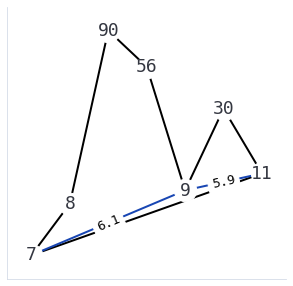

In [10]:
from copy import deepcopy
def process(arc, offset, length):
    new = deepcopy(arc)
    new.v1 = (new.v1 + offset) % length
    new.v2 = (new.v2 + offset) % length
    new.v1, new.v2 = sorted([new.v1, new.v2])
    return new

draw(dims2, [process(arc, offset, len(dims2)) for arc in included])

[1, 2, 0]
[0, 1, 0]
[4, 0, 0]
[4, 6, 5]
[4, 6, 0]
[6, 0, 0]
[2, 3, 0]
[0, 0, 1]
[3, 4, 0]
[(0, 1, 2), (4, 5, 6), (0, 4, 6), (0, 2, 3), (0, 3, 4)]


/home/nicholas/anaconda3/envs/ds/lib/python3.9/site-packages/numpy/core/numeric.py:1223: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = asanyarray(a)


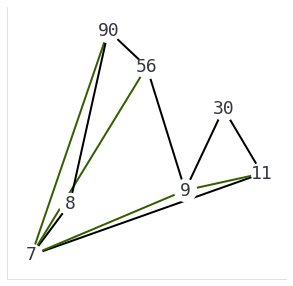

In [20]:
cost = 0
for a in arcs:
    if hasattr(a, 'matrix_product'):
        del a.matrix_product

mats = np.roll(mats1, offset, axis=0)
        
def triangulate(node):
    if node.v2 - node.v1 == 1:
        node.triangulation = set()
        return node.triangulation
    elif node.v2 - node.v1 == 2:
        v3 = node.v1 + 1
        node.triangulation = {(node.v1, node.v2, v3)}
        return node.triangulation
    
    jumps = {}
    rjumps = {}
    for e in node.ceiling:
        jumps[e.v1] = (e, e.v2)
        rjumps[e.v2] = (e, e.v1)
    
    node.triangulation = []
    if dims[node.v1] <= dims[node.v2]:                
        vstart = node.v1
        vend = node.v2
        incr = 1
        edge_dict = jumps
    else:        
        vstart = node.v2  
        vend = node.v1
        incr = -1        
        edge_dict = rjumps

    curr_edges = set()
    curr = vstart        
    while curr != vend:            
        if curr in edge_dict:
            (edge, dest) = edge_dict[curr]         
            curr_edges.update(edge.triangulation)
            curr_edges.add(tuple(sorted((vstart, curr, dest))))
            curr = dest
        else:
            curr_edges.add(tuple(sorted((curr, curr + incr, vstart))))
            curr = curr + incr

    node.triangulation = curr_edges
    return node.triangulation

m = postorder_traversal(triangulate, leaves)
triangles = []
dregs = set()
for edge in m:    
    relabeled = [(v + offset) % len(dims2) for v in edge]    
    v1, v2, v3 = relabeled
    print(relabeled)
    if len(set(relabeled)) == 3:        
        triangles.append(tuple(sorted(relabeled)))
    else:
        dregs.update({v1, v2, v3})

# if dregs:
#     v1, v2, v3 = tuple(dregs)
#     triangles.append(tuple(sorted(dregs)))

class Harc:
    def __init__(self, v12):
        self.v1, self.v2 = sorted(v12)
        self.cutoff = 1

print(triangles)
edges = []
for (v1, v2, v3) in triangles:
    edges += [(v1, v2), (v1, v3), (v2, v3)]

draw(dims2, [], [Harc(ha) for ha in edges])

In [21]:
import itertools
from collections import defaultdict
graph = defaultdict(set)
for (v1, v2) in edges:
    graph[v1].add(v2)
    graph[v2].add(v1)

tris = set()
for v, neighbors in graph.items():
    for i, j in itertools.combinations(neighbors, 2):
        if j in graph[i]:
            tris.add(tuple(sorted((v, i, j))))

tris

{(0, 1, 2), (0, 2, 3), (0, 3, 4), (0, 4, 6), (4, 5, 6)}

In [22]:
products = {}
for (v1, v2, v3) in triangles:
    for va, vb in ((v1, v2), (v2, v3)):
        if vb - va == 1:
            products[(va, vb)] = mats1[va]

while triangles:
    new_triangles = []
    for (v1, v2, v3) in triangles:
        if (v1, v2) in products and (v2, v3) in products:
            print(v1, v2, v3)
            products[(v1, v3)] = np.dot(products[(v1, v2)], products[(v2, v3)])
        else:
            new_triangles.append((v1, v2, v3))
    
    triangles = new_triangles

products[(0, len(dims2) - 1)]

0 1 2
4 5 6
0 2 3
0 3 4
0 4 6


array([[ -529.89362116, -1400.40520194,  -660.57495532,  1951.75461091,
        -1475.28592079,   220.50498481, -2070.56199166,  3949.03708291,
         2309.27847685,  -763.62957397, -1408.46672983],
       [ -721.79508466,   937.86017113,  -380.89583038,  1008.48615212,
         1050.99402488,   282.32681081,  2464.16919616, -2248.1122408 ,
         -868.0765246 ,    73.48291441,   806.01821554],
       [ 1247.36523561, -3571.17451251, -1316.55088377,  1725.75353084,
        -1815.0284336 ,  -883.43107084, -1262.02339691,  3611.62633645,
         3373.80900417, -1766.37176723, -2024.25716776],
       [  462.1689453 ,  2357.76882062, -1036.73989143, -1423.47614466,
        -1686.50335736,   786.06268026, -2039.14534732,  -386.66756292,
         -315.84513933,   312.49761154, -1967.4714886 ],
       [ -123.22188292,  -172.09687927,  2530.74535982,  -372.58653039,
          568.11845325, -1566.68050438, -1243.85687646, -1126.54900728,
         1619.89215677, -1489.30042059,  1916.888757

Idea:
 - Construct triangulation using postorder traversal of original graph
 - Cycling all the edges doesn't remove this triangulation, and you can
   remove the double vertex
 - While still extant triangulations, loop through each one
 - If two edges are figured out, compute the other

In [ ]:
products[(0, len(dims2) - 1)].shape

(7, 11)

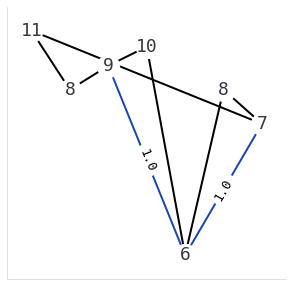

In [ ]:
dims = np.array([11, 8, 9, 10, 6, 8, 7])

harcs = []

i1 = 0
i2 = 1

while i2 < len(dims):
    new_i2 = i2 + 1
    if new_i2 != len(dims) and dims[new_i2] <= dims[i2]:
        # current arc can continue
        i2 = new_i2
    else:
        # new arc must be made
        harcs.append((i1, i2))
        i1 = i2
        i2 = new_i2

class Harc:
    def __init__(self, v12):
        self.v1, self.v2 = v12
        self.cutoff = 1

draw(dims, [Harc(ha) for ha in harcs])

In [ ]:
harcs

[(0, 1), (1, 2), (2, 4), (4, 6)]